# G-C content was calculated incorrectly
## Wiki/[GC content](https://en.wikipedia.org/wiki/GC-content)
---

# The shortest chain which contains all hexamers from all 4 bases (A,T,C,G).

## How to generate the reads?
Create a slots (`np.array`) for reads.\
If the given hexamer does not exists in any reads, then append it somewhere with the following rules:
- Append the hexamer to the read where the overlap is the biggest. 
    - If more than one exists append the shortest read.
- If there is no overlap anywhere, then 
    - append the hexamert to a new read (if it is possible) OR
    - append to the shorthest existing read

In [1]:
# packages
import numpy as np
import matplotlib.pyplot as plt
import itertools

# fontsize for plots
FS=12

In [2]:
# functions
def combine_strings(string):
    ''' Add strings to each other. '''
    return ''.join(string)


def generate_k_mer_list(possible_bases, k_mer):
    ''' All possible repeated variations of k-mers. '''
    itr_prod = itertools.product(possible_bases, repeat=k_mer)
    k_mer_list = []
    for i in range(len(possible_bases)**k_mer):
        k_mer_list.append(combine_strings(next(itr_prod)))
    return np.array(k_mer_list)


def shortest_chain(k_mers): ## --> ChatGPT code, promt: given the following array; create the shortest string which contains all element of the given array
    '''
    With the help of ChatGPT, the shortest string that contains all possible hexamers,
    extending it only as much as necessary so that if a given k-mer already exists in the chain, it is not added again.
    '''
    result = k_mers[0]
    for i in range(1, len(k_mers)):
        overlap = len(k_mers[i]) - 1
        # If the k-mer already exists in the word chain, do not append it to the result.
        if result.count(k_mers[i]) == 0: # added to chatGPT code
            while overlap >= 0: # Backtracking until the k-mer matches the end of the chain.
                if result.endswith(k_mers[i][:overlap]):
                    break
                overlap -= 1
            result += k_mers[i][overlap:]
    return result


def kmers_sorted_by_frequency(chains, k_mers):
    ''' The frequency of possible k-mers in a given sequence in descending order. '''
    numbers = {}
    for element in k_mers:
        n=0
        for chain in chains:
            n += chain.count(element)
            numbers[element] = n
    sort_numbers = np.array(sorted(numbers.items(), key=lambda x:x[1], reverse=True))
    return sort_numbers


def run_chech(chains, k_mers, print_count=True, num_of_skipped_bases=0):
    ''' Counting identical frequencies --> how many k-mers appear n times in a sequence. '''
    sort_numbers = kmers_sorted_by_frequency(chains, k_mers)
    count = []
    for i in range(1, int(sort_numbers[0,1])+1):
        count.append([i, sum(np.array(sort_numbers[:,1], dtype=int) == i)])
    # missing elemets 
    count.append([0, sum(np.array(sort_numbers[:,1], dtype=int) == 0)])
    if print_count:
        print('\\begin{run_chech()}')
        print(f'  Length of the chain: {len(combine_strings(chains)) + num_of_skipped_bases}')
        print('  frequency - the number of k-mers:')
        for i in range(len(count)):
            # print if element type is not missing
            if count[i][1] !=0:
                print(f'  {count[i][0]} - {count[i][1]}')
        print('\end{run_chech()}')
    else:
        return count  
    return None


def calculate_GC_ratio(reads, tol=0.1):
    ''' Calculate the GC content trought reads '''
    averages=[]
    pct_in_tol_intervall = []
    for i, read in enumerate(reads):
        list_of_G_or_C=[]
        first_base_num, iterations = next(((1., i) if b == 'G' else (0., i) for i, b in enumerate(read) if b in 'GC'), (0,0))
        averages.append(iterations*[first_base_num])
        for base in range(iterations, len(read)):
            if read[base] == 'G':
                list_of_G_or_C.append(1.)
                averages[i].append(np.mean(list_of_G_or_C))
            elif read[base] == 'C':
                list_of_G_or_C.append(0.)
                averages[i].append(np.mean(list_of_G_or_C))
            else:    
                averages[i].append(np.mean(list_of_G_or_C))
        in_tolerance_interval = (np.array(averages[i]) >= (0.5-tol)) & (np.array(averages[i]) <= (0.5+tol))
        pct_in_tol_intervall.append( sum(in_tolerance_interval[iterations:]) / (len(averages[i])-iterations) )
    return np.array(averages, dtype='object'), np.array(pct_in_tol_intervall)

def plot_gc_ratio_for_a_read(read_GC_avg, pct):
    ''' Plot the G-C ratio trought a read '''
    plt.figure(figsize=(8,6))
    plt.plot(read_GC_avg, 'o--', c='blue', ms=10)
    plt.xlim(0,240)
    plt.ylim(0,1)
    plt.hlines(0.6, 0, 240, color='r')
    plt.hlines(0.4, 0, 240, color='r')
    plt.title(f'G-C ratio in a given read\n{pct*100:.2f}% of bases in the interval', fontsize=FS+3)
    plt.ylabel('G-C ratio', fontsize=FS)
    plt.xlabel('read index', fontsize=FS)
    plt.grid()

In [3]:
hexamers = generate_k_mer_list('ACTG', 6)

#### Randomizations is needed better for G-C ratio.

In [4]:
# random seed for reproduction
np.random.seed(137)
np.random.shuffle(hexamers)

---

In [5]:
def fill_k_mers_into_reads(reads, k_mers, min_overlap, num_of_while_loops):
    
    # an empty list for the skipped k-mers
    skipped_k_mers = []
    
    for i, k_mer in enumerate(k_mers):
            
        # if the k-mer does not exists in any read, then put append it using the rules.
        if not any(k_mer in read for read in reads):
                        
            overlaps_in_reads = []
            # Iterate trough all reads
            for j in range(len(reads)):   
                # the number of possible overlapping bases
                overlap = len(k_mer) - 1
                # backtracking until the k-mer matches to the end of read j REWRITE
                while overlap >= 0: 
                        # if the read end with the same character(s) as the hexamer begin.
                        if reads[j].endswith(k_mer[:overlap]):
                            # save the number of overlapping characters
                            overlaps_in_reads.append(overlap)
                            # break the while loop
                            break
                        # there is no overlap with n character --> try with n-1
                        overlap -= 1
        
            # if all overlaps are less then or equal to the minimal overlap 
            if np.all(np.array(overlaps_in_reads) <= min_overlap):
                # skip the k-mer
                skipped_k_mers.append(k_mer)                                  
            # else there is/are overlap(s) somewhere 
            else:          
                # find the indices of maximal overlaps
                max_overlaps_indices = np.where(overlaps_in_reads == np.max(overlaps_in_reads))[0]
                # find too long reads 
                too_long_reads = np.where((np.vectorize(len)(reads) + max(overlaps_in_reads)) >= 239)[0]    
                # use only those indices what are not too long
                selected_reads = np.setdiff1d(max_overlaps_indices, too_long_reads)
                
                # if more than one minimal overlap exists
                if len(selected_reads) > 1:                   
                    # get the length of selected reads
                    length_of_selected_reads = np.vectorize(len)(reads[selected_reads])
                    # find the indices of the minimal read lenght
                    min_read_len_idx = np.where(length_of_selected_reads == np.min(length_of_selected_reads))[0]
                    # random seed for reproduction
                    np.random.seed(137)
                    # append the hexamer (w/o overlap) to one of the shortest read                  
                    reads[selected_reads[np.random.choice(min_read_len_idx)]] += k_mer[max(overlaps_in_reads):]
                    
                # else one minimal overlap exists
                elif len(selected_reads) == 1:
                    #append the hexamer (w/o overlap)
                    reads[selected_reads[0]] += k_mer[max(overlaps_in_reads):]
                else:
                    # skip the k-mer
                    skipped_k_mers.append(k_mer)
     
        # print 
        print(f'{((i+1)/len(k_mers)*100):.0f}% finished, {num_of_while_loops} while loop(s) remaining. {10*" "}', end='\r')
              
    return reads, skipped_k_mers

In [6]:
def generate_reads_v3(k_mers, num_of_reads, min_overlap=None, max_while_counter=5, print_anything=True):
    ''' Generate reads '''
    # the result will be stored in 'reads' var. as a numpy array
    reads = np.empty(num_of_reads, dtype='U300')
    
    
    # fill all reads with an initial k-mer
    reads[:num_of_reads] = k_mers[:num_of_reads]
    
    skipped_k_mers = k_mers[num_of_reads:].copy()


    if min_overlap == None:
        min_overlap = len(k_mers[0]) // 2
        print(f'minimum overlap set to {min_overlap}')

    while_counter = 0
    
    #k_mers_copy = k_mers.copy()
    while max_while_counter >= while_counter:
        k_mers_len_before = len(skipped_k_mers)
        reads, skipped_k_mers = fill_k_mers_into_reads(reads, skipped_k_mers, min_overlap, max_while_counter-while_counter)
        k_mers_len_after = len(skipped_k_mers)
        
        if len(skipped_k_mers) == 0:
            if print_anything:
                print(f'No more skipped k-mer after {while_counter} loop. {20*" "}')
            break
        if k_mers_len_before == k_mers_len_after:
            if print_anything:
                print(f'Cannot append more k-mers after {while_counter} loop. {20*" "}')
            break 
        
        while_counter+=1        
        
    if print_anything:
        print(f'Number of skipped k-mers: {len(skipped_k_mers)}  {20*" "}')
    if any(np.vectorize(len)(reads) > 240) & print_anything:
        print('Something went wrong: there is a too long read.')

    return reads, np.array(skipped_k_mers)

---
---
---

### Generate reads with random parameters
```python
num_of_reads, min_overlap = 26, 2
reads, skipped_hexamers = generate_reads_v3(hexamers, num_of_reads=num_of_reads, min_overlap=min_overlap, max_while_counter=20)
print(f'   Lenght  {num_of_reads}*240 = {num_of_reads*240} bases')

if sum((240- np.vectorize(len)(reads)) // 6) > len(skipped_hexamers):
    print('Possible to fill reads.')
else:
    print('Not possible to fill reads, generate more reads!')
```

### Find the minimal number of reads
```python
break_first_loop = False
for num_of_reads in range(25, 30):
    for min_overlap in [3,2,1,0]:
    
        reads, skipped_hexamers = generate_reads_v3(hexamers, num_of_reads=num_of_reads, min_overlap=min_overlap, max_while_counter=20, print_anything=False)

        if sum((240 - np.vectorize(len)(reads)) // 6) > len(skipped_hexamers):
            print(f'Possible generation: N_reads={num_of_reads}, min_overlap={min_overlap}')
            print(f'Number of skipped k-mers: {len(skipped_hexamers)}')
            print(f'   Lenght  {num_of_reads}*240 = {num_of_reads*240} bases')
            break_first_loop=True
            break
    if break_first_loop:
        break
```
**result**: 
```python
num_of_reads = 27
min_overlap = 2
```

In [7]:
num_of_reads, min_overlap = 27, 2
reads, skipped_hexamers = generate_reads_v3(hexamers, num_of_reads=num_of_reads, min_overlap=min_overlap, max_while_counter=20)

read_gc_avgs, pct_in_tol_intervall = calculate_GC_ratio(reads)
reads = reads[np.argsort(pct_in_tol_intervall)]

Cannot append more k-mers after 10 loop.                     
Number of skipped k-mers: 85                      


### Append the skipped hexamers to the reads
Try to get a better G-C ratio for reads

In [8]:
def append_skipped_k_mers(reads, skipped_k_mers):
    ''' Append skipped k-mers to the stast of the worst scored reads '''
    # use list to rewrite its elements
    reads = list(reads.copy())
    
    read_gc_avgs, pct_in_tol_intervall = calculate_GC_ratio(reads)

    # filter hexamers that do not contain 'C' and 'G'
    skipped_k_mers_wo_GC = skipped_k_mers[~np.char.find(skipped_k_mers, 'C') >= 0]
    skipped_k_mers_wo_GC = skipped_k_mers_wo_GC[~np.char.find(skipped_k_mers_wo_GC, 'G') >= 0]
    skipped_k_mers_with_GC = skipped_k_mers[skipped_k_mers != skipped_k_mers_wo_GC]

    # sort the hexamers by the variability of the ratio
    skipped_gc_avgs, _ = calculate_GC_ratio(skipped_k_mers_with_GC)
    increase_C_ratio = list(skipped_k_mers_with_GC[skipped_gc_avgs[:,-1] < 0.5])
    increase_G_ratio = list(skipped_k_mers_with_GC[skipped_gc_avgs[:,-1] > 0.5])
    no_change_for_ratios = list(np.append(skipped_k_mers_with_GC[skipped_gc_avgs[:,-1] == 0.5], skipped_k_mers_wo_GC))
    
    
        # how to append the skipped hexamers to the start of the reads?

    # calculate the mean of G-C ratio 
    gc_mean_per_read = np.array([np.mean(avg) for avg in read_gc_avgs])
    # sort it by the out of tolerance level --> now the first one is the worst
    sorted_gc_mean_per_read = gc_mean_per_read[np.argsort(pct_in_tol_intervall)]

        # what should be appended to the start of the read?

    # if the G-C mean is less than 0.5 --> G must appende else C
    append_G_to_read = sorted_gc_mean_per_read < 0.5

    reads = list(reads)
    len_k_mer = len(skipped_k_mers[0])
    while len(increase_G_ratio) or len(increase_C_ratio):
        for i, read in enumerate(reads):
            if len(read) + len_k_mer <= 240:
                if append_G_to_read[i]:
                    try:
                        reads[i] = increase_G_ratio[0] + read
                        del increase_G_ratio[0]
                    except: pass
                else:
                    try:
                        reads[i] = increase_C_ratio[0] + read
                        del increase_C_ratio[0]
                    except: pass
        
        
    reads = np.array(reads)
    reads = reads[np.argsort(np.vectorize(len)(reads))]
    reads = list(reads) 
    while len(no_change_for_ratios):
        for i in range(len(reads)):
            if len(reads[i]) + len_k_mer <= 240:
                try:
                    reads[i] += no_change_for_ratios[0] 
                    del no_change_for_ratios[0]
                except:
                    pass
               
    _, pct_in_tol_intervall = calculate_GC_ratio(reads)
    reads = np.array(reads)
    return reads[np.argsort(pct_in_tol_intervall)]


In [9]:
supplemended_reads = append_skipped_k_mers(reads, skipped_hexamers)

In [10]:
run_chech(supplemended_reads, hexamers)

\begin{run_chech()}
  Length of the chain: 6281
  frequency - the number of k-mers:
  1 - 2423
  2 - 1339
  3 - 298
  4 - 34
  5 - 2
\end{run_chech()}


---

In [11]:
# recalculate G-C ratio
read_gc_avgs, pct_in_tol_intervall = calculate_GC_ratio(supplemended_reads)
print(f'The score of simulation (mean +/- std) = ({np.mean(pct_in_tol_intervall)*100:.2f} +/- {np.std(pct_in_tol_intervall)*100:.2f}) %')

The score of simulation (mean +/- std) = (82.60 +/- 10.14) %


In [15]:
pct_in_tol_intervall

array([0.59903382, 0.6371308 , 0.67659574, 0.72222222, 0.72844828,
       0.73181818, 0.7375    , 0.75105485, 0.77542373, 0.77916667,
       0.7991453 , 0.80269058, 0.82327586, 0.85957447, 0.85964912,
       0.86075949, 0.8697479 , 0.87111111, 0.90707965, 0.91025641,
       0.92436975, 0.92444444, 0.93162393, 0.93644068, 0.93832599,
       0.96581197, 0.9787234 ])

The first five most incorrect reads:


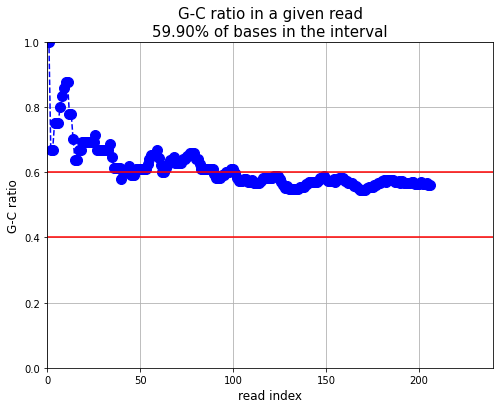

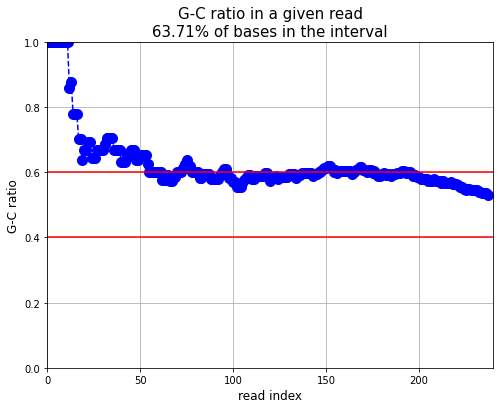

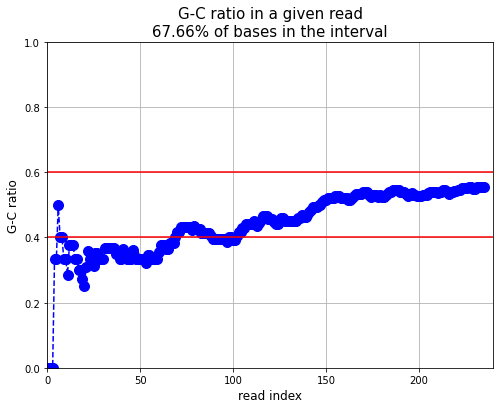

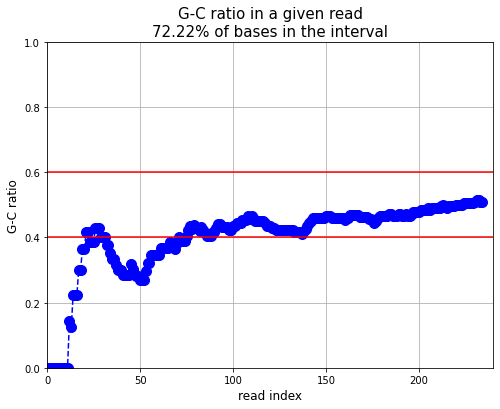

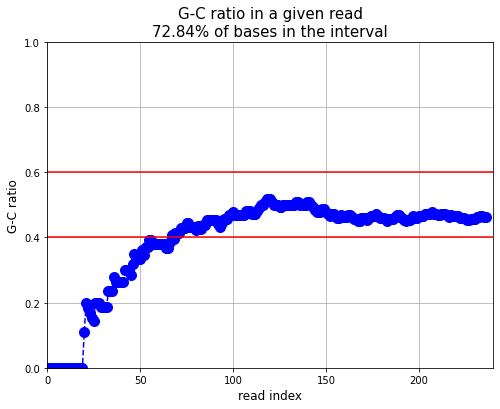

In [13]:
print('The first five most incorrect reads:')
for i in range(5):
    plot_gc_ratio_for_a_read(read_gc_avgs[i], pct_in_tol_intervall[i])

The first five best reads:


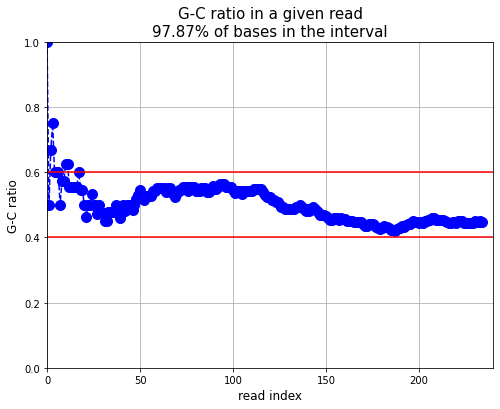

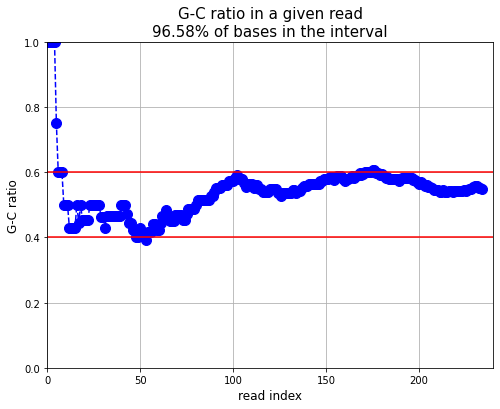

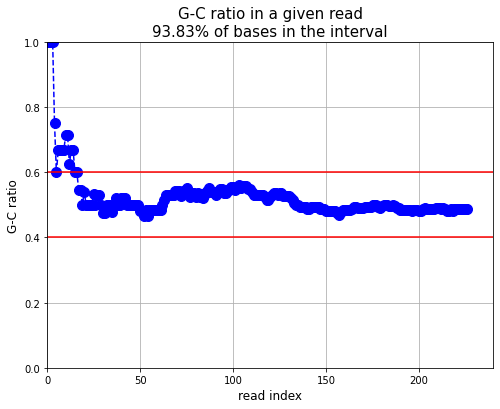

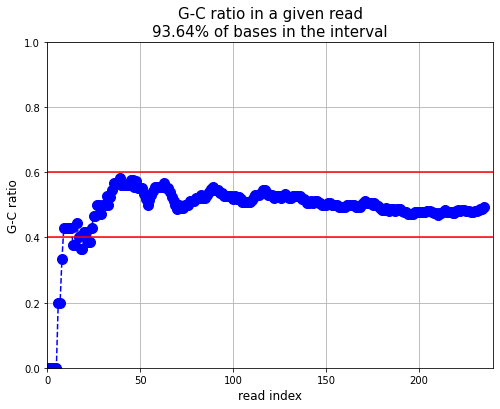

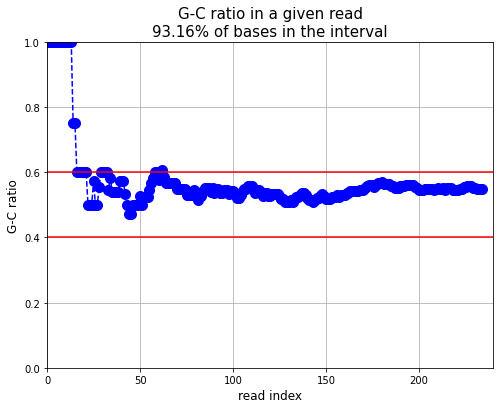

In [14]:
print('The first five best reads:')
for i in range(1,6):
    plot_gc_ratio_for_a_read(read_gc_avgs[-i], pct_in_tol_intervall[-i])